# 2022 ACTL3143 Assignment: Mortality Rate Prediction Using Neural Networks
By Kelly Chu (z5255293)

## 1. Introduction

The project will use past population data to predict future mortality rates for Australia. This is a regression type problem with log mortality rates $log(m_x)$ regressed against calendar year $t$, age $x$ and gender to forecast mortality rates. 

We begin by fitting a baseline Lee-Carter model before looking to how predictions can be improved with deep learning models.

## 2. Data Preparation

### 2.1 Load packages and helper functions

Packages

In [3]:
from pathlib import Path
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

from tensorflow.keras.utils import timeseries_dataset_from_array

from scipy.linalg import svd
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Concatenate, Dropout, Embedding, Flatten, Dense, BatchNormalization, LSTM, GRU
import keras_tuner as kt
from keras.optimizers import Adam

from sklearn.metrics import  mean_squared_error

Helper functions

In [4]:
def plotPredictions(data, model, datasplit, G):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

    plt.suptitle(f"{country} {G} {model} Prediction on {datasplit} Set")

    ax1.set_ylim(-9.5, 0)
    ax1.set_xlim(-9.5, 0)
    ax2.set_xlim(-9.5, 0)
    ax2.set_ylim(-1.5, 1.5)

    ax1.scatter(data['logmx'], data['pred_logmx'])
    ax1.set_ylabel("Predictions")
    ax1.set_xlabel("True values")
    ax1.set_title(f"{datasplit} Predictions vs Actual")
    
    xl = ax1.get_xlim()
    yl = ax1.get_ylim()
    shortestSide = min(xl[1], yl[1])
    ax1.plot(xl, yl, color="black", linestyle="--")

    sns.regplot(x = data['logmx'], y = data['residuals'], data = None, scatter = True, ax=ax2, truncate = False)
    ax2.set_title(f"{model} {datasplit} Residuals vs log(mx)")

    sns.regplot(x = data['Age'].astype('int'), y = data['residuals'], data = None, scatter = True, ax=ax3, truncate = False)
    ax3.set_title(f"{model} {datasplit}  Residuals vs Age")

    sns.regplot(x = data['Year'].astype('int'), y = data['residuals'], data = None, scatter = True, ax=ax4, truncate = False)
    ax4.set_title(f"{model} {datasplit}  Residuals vs Year")

    plt.savefig(f"plots/{country} {G} {model} Prediction on {datasplit} Set")

In [ ]:
def ratesLineAges(Gender):
    gender_mort = all_mort[all_mort['Gender'] == Gender].drop(columns = ['Gender'])

    # pivot data to acceptable form for heatmap
    plot_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year') 
    plot_data_t = plot_data.transpose()

    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=plot_data_t.columns.min(), vmax=plot_data_t.columns.max())
    colormap = cm.RdBu

    # plot
    for n in plot_data_t.columns:
        plt.plot(plot_data_t[n], color=colormap(normalize(n)))

    # setup the colorbar
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(plot_data_t.columns)
    plt.colorbar(scalarmappaple)

    # add axis labs
    plt.title(f"{country} {Gender} Log-Mortality Rates Over Ages")
    plt.xlabel('Calendar Years')
    plt.ylabel('Log-Mortality Rates')

    # show the figure
    plt.savefig(f"plots/{country} {Gender} Log-Mortality Rates Over Ages")
    plt.show()


In [129]:
def ratesLineYears(Gender):
    gender_mort = all_mort[all_mort['Gender'] == Gender].drop(columns = ['Gender'])

    # pivot data to acceptable form for heatmap
    plot_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year') 
    plot_data_t = plot_data.transpose()

    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=plot_data_t.columns.min(), vmax=plot_data_t.columns.max())
    colormap = cm.RdBu

    # plot
    for n in plot_data_t.columns:
        plt.plot(plot_data_t[n], color=colormap(normalize(n)))

    # setup the colorbar
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(plot_data_t.columns)
    plt.colorbar(scalarmappaple)

    # add axis labs
    plt.title(f"{country} {Gender} Log-Mortality Rates Over Ages")
    plt.xlabel('Calendar Years')
    plt.ylabel('Log-Mortality Rates')

    # show the figure
    plt.savefig(f"plots/{country} {Gender} Log-Mortality Rates Over Ages")
    plt.show()


In [5]:
def residualsHeatmap (data, model, datasplit, gender):

    compare = max(abs(data.residuals.min()), abs(data.residuals.max()))
    minvalue = -compare
    maxvalue = compare

    # pivot data to acceptable form for heatmap
    plot_data = pd.pivot_table(data, values = 'residuals', index = 'Age', columns = 'Year')

    # plot heatmap
    heatmap = sns.heatmap(data = plot_data,vmin = -1.5, vmax = 1.5, cmap = "RdBu_r").invert_yaxis()

    # add title and labels
    plt.title(f"{country} {gender} {model} {datasplit} Residuals Residuals")
    plt.xlabel('Calendar Year t')
    plt.ylabel('Age x')
    plt.savefig(f"plots/{country} {gender} {model} {datasplit} Residuals Heatplot")

In [146]:
def plotRatesVsAge(data, model, datasplit, gender):
    if datasplit == 'Actual':
        plot_data = pd.pivot_table(data, values = 'logmx', index = 'Age', columns = 'Year')
    else: 
        plot_data = pd.pivot_table(data, values = 'pred_logmx', index = 'Age', columns = 'Year')
    
    # setup the normalization and the colormap
    normalize = mcolors.Normalize(vmin=plot_data.columns.min(), vmax=plot_data.columns.max())
    colormap = cm.RdBu

    # plot
    for n in plot_data.columns:
        plt.plot(plot_data[n], color=colormap(normalize(n)))

    # setup the colorbar
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(plot_data.columns)
    plt.colorbar(scalarmappaple)

    # add axis labs
    plt.title(f"{country} {gender} {model} Predictions on {datasplit} ")
    plt.xlabel('Age')
    plt.ylabel('Log-Mortality Rates')
    plt.ylim(-10,0)

    # show the figure
    plt.savefig(f"plots/{country} {gender} {model} Predictions {datasplit} Set")
    plt.show()


In [7]:
def plot_train_history(history, model):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{country} {model} Training History")
    plt.legend()
    plt.show()
    plt.savefig(f"plots/{country} {model} Training History")

In [8]:
def nnPredictions(model, x_data, y_data):
    
    y = y_data
    pred = model.predict(x_data).flatten()

    merge = pd.DataFrame({"pred_logmx": pred, "logmx": y})
    merge['pred_mx'] = merge['pred_logmx'].apply(lambda x: np.exp(x))
    merge['mx'] = merge['logmx'].apply(lambda x: np.exp(x))
    merge['residuals'] = merge['pred_logmx'] - merge['logmx']
    merge['loss'] = merge['residuals'] ** 2

    return merge

### 2.2 Load data
The project uses the Australia population data set available on Human Mortality Database (HMD) - labelled as "AUS".
https://www.mortality.org/File/GetDocument/hmd.v6/AUS/STATS/Mx_1x1.txt 

In [9]:
country = 'AUS'

random.seed(17)

if not Path("Mx_1x1.txt").exists():
    print("Downloading dataset")
    !wget https://github.com/kchu1711/actl3143/blob/a1e55f150a0dedf6360d206f666b52f4425843d2/assignment/Mx_1x1.txt

all_mort = pd.read_csv('Mx_1x1.txt', skiprows= 2, sep = '\s+')
print(f"shape of DataFrame: {all_mort.shape}")


shape of DataFrame: (10989, 5)


In [10]:
all_mort.head()

,Year,Age,Female,Male,Total
0,1921,0,0.059987,0.076533,0.068444
1,1921,1,0.012064,0.014339,0.013225
2,1921,2,0.005779,0.006047,0.005916
3,1921,3,0.002889,0.004197,0.003554
4,1921,4,0.003254,0.003254,0.003254


### 2.3 Data Formatting
- Replace "." with NA
- Encode age bracket "110+" as 110 - will be removed later on as we are investigating ages 0 to 99
- Converting age, mx and gender to int, float and category respectively

In [11]:
# make data wider to longer
all_mort = all_mort.melt(id_vars=['Year','Age'], value_vars =['Female','Male'], var_name = "Gender", value_name='mx')

#change 110+ to 110
all_mort.loc[all_mort['Age'] == '110+', 'Age'] = '110'

#replace . or 0 with NA
all_mort.loc[all_mort['mx'] == '.', 'mx'] = np.nan
all_mort.loc[all_mort['mx'] == 0, 'mx'] = np.nan

#convert type
all_mort['Gender'] = all_mort['Gender'].astype('category')
all_mort['Age'] = all_mort['Age'].astype('int')
all_mort['mx'] = all_mort['mx'].astype('float')
all_mort.dtypes

Year         int64
Age          int32
Gender    category
mx         float64
dtype: object

### 2.4 Data Pre-processing
Pre-processing steps were then applied so that the data is in the proper format for our models. This includes:
- Select calendar years t from 1950
- Select ages to be of values between 0 to 99 years
- Create *logmx* column which is the log of the mx column

In [12]:
#keep rows where year is within range and age is between 0 and 100
all_mort = all_mort[(all_mort['Age'] >= 0) & (all_mort['Age'] < 100)]

#log mx
all_mort['logmx'] = np.log(all_mort['mx'])

# set index to be equal to the Year
all_mort['t'] = pd.to_datetime(all_mort['Year'], format='%Y')
all_mort.set_index('t', inplace=True)

After cleaning, there are no null values and all features are of expected type.

In [13]:
# check for null values
all_mort.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19800 entries, 1921-01-01 to 2019-01-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Year    19800 non-null  int64   
 1   Age     19800 non-null  int32   
 2   Gender  19800 non-null  category
 3   mx      19800 non-null  float64 
 4   logmx   19800 non-null  float64 
dtypes: category(1), float64(2), int32(1), int64(1)
memory usage: 715.6 KB


In [14]:
all_mort.head()

,Year,Age,Gender,mx,logmx
t,,,,,
1921-01-01,1921,0,Female,0.059987,-2.813627
1921-01-01,1921,1,Female,0.012064,-4.417529
1921-01-01,1921,2,Female,0.005779,-5.153525
1921-01-01,1921,3,Female,0.002889,-5.846845
1921-01-01,1921,4,Female,0.003254,-5.727870


## 3. Data Exploration

The below heatmap illustrates the relationship between age x and the calendar year t. From the colour scale, red and blue represents low and high mortality rates respectively. 

We can observe the following patterns:
- Age effect: looking for vertical patterns in the heatmap, we can observe that in a given year, mortality rates tends to increase as age increases
- Period effect: looking for horizontal patterns in the heatmap, we can observe that for a given year, mortality rates tends to decrease as calendar year increases

In [ ]:
def rateHeatmap(Gender):
    gender_mort = all_mort[all_mort['Gender'] == Gender].drop(columns = ['Gender'])

    # find min value and max value to set the scale of the label to be consistent between male and female
    minvalue = all_mort.logmx.min().min()
    maxvalue = all_mort.logmx.max().max()

    # pivot data to acceptable form for heatmap
    plot_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year')

    # plot heatmap
    heatmap = sns.heatmap(data = plot_data,vmin = minvalue, vmax = maxvalue, cmap = "RdBu_r", square=True).invert_yaxis()

    # add title and labels
    plt.title(f"{country} {Gender} Log-Mortality Rates")
    plt.xlabel('Calendar Year t')
    plt.ylabel('Age x')
    plt.savefig(f"plots/{country} {Gender} Log-Mortality Rates")

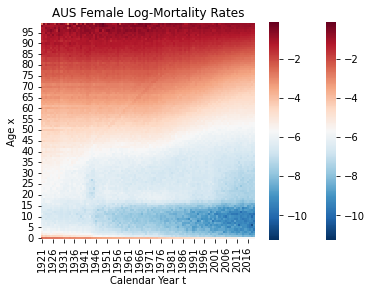

In [122]:
rateHeatmap('Female')

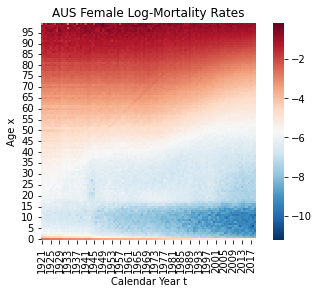

In [123]:
rateHeatmap('Male')

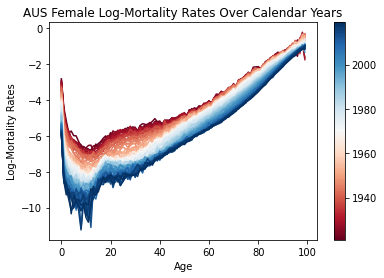

In [127]:
ratesLineYears('Female')

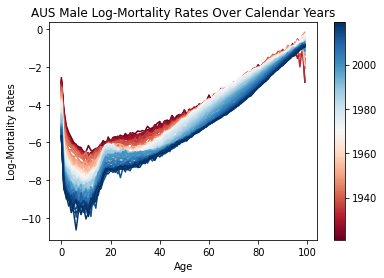

In [128]:
ratesLineYears('Male')

In the below plot, we can observe that improvements in mortality over the past decades is more evident in younger ages - particularly of infants and children whereas those in older ages have experienced relatively less mortality improvements.

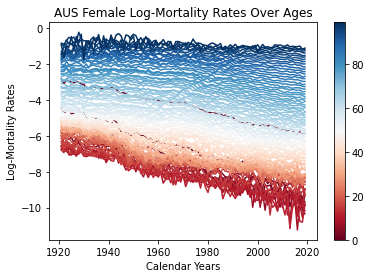

In [130]:
ratesLineAges('Female')

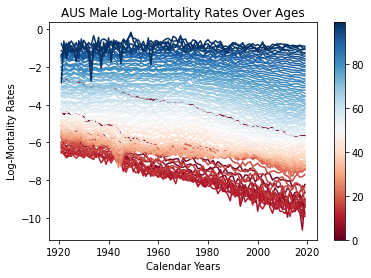

In [131]:
ratesLineAges('Male')

## 4. Split into training, validation and test set

We then split the data into approximately 60% training, 20% validation and 20% test set, split by calendar year. The training set will contain only the observations prioer to the ones from the test set so that no future observations are used in constructing the forecast. This prevents any leaks that may cause a bias in estimation which leads to deviations in prediction error while applying the model to new unseen data.

In [105]:
# find year to split data at 
minYear = gender_mort.Year.min()
maxYear = gender_mort.Year.max()
interval = (maxYear - minYear)/10
traincut = int(minYear + interval * 6)
valcut = int(minYear + interval * 8)
trainall = all_mort[all_mort['Year'] <= traincut]
valall = all_mort[(all_mort['Year'] > traincut) & (all_mort['Year'] <= valcut)]
testall = all_mort[all_mort['Year']> valcut]

print(f"trainall shape: {trainall.shape}, min year: {trainall.Year.min()}, max year: {trainall.Year.max()}, number of years: {trainall.Year.nunique()}")
print(f"valall shape: {valall.shape}, min year: {valall.Year.min()}, max year: {valall.Year.max()}, number of years: {valall.Year.nunique()}")
print(f"testall shape: {testall.shape}, min year: {testall.Year.min()}, max year: {testall.Year.max()}, number of years: {testall.Year.nunique()}")


trainall shape: (11800, 5), min year: 1921, max year: 1979, number of years: 59
valall shape: (4000, 5), min year: 1980, max year: 1999, number of years: 20
testall shape: (4000, 5), min year: 2000, max year: 2019, number of years: 20


## 5. Baseline Model: Lee-Carter model

In [106]:
# select gender from train
trainfemale = trainall[trainall["Gender"]== "Female"].drop(columns = "Gender")
valfemale = valall[valall["Gender"]== "Female"].drop(columns = "Gender")
testfemale = testall[testall["Gender"]== "Female"].drop(columns = "Gender")

trainmale = trainall[trainall["Gender"]== "Male"].drop(columns = "Gender")
valmale = valall[valall["Gender"]== "Male"].drop(columns = "Gender")
testmale = testall[testall["Gender"]== "Male"].drop(columns = "Gender")

### 5.1 Parameter Estimation on testing Data
The model calculates the logarithm of the central death rate $log(m_{x,t})$ at age $x$ in the calendar year $t$ as:
$$\log(m_{x,t}) = \mathbb{a}_x + b_x k_t + e_{x,t} \tag{$1$} $$
We will calculate the parameters from first principles - methodology can be found in the report appendix

In [21]:
def LCParameters(train):
    #Step 1
    a_x = train.groupby('Age')['logmx'].mean()

    # Step 2
    train = train.assign(
        a_x = train.groupby(by = 'Age')['logmx'].transform('mean'), 
        mx_adj = lambda x: x['logmx'] - x['a_x']
    )
    rates_mat = pd.pivot_table(train, values = 'mx_adj', index = 'Age', columns = 'Year')

    # Step 3
    u, s, vT = svd(rates_mat)

    # Step 4
    b_x = u[:,0] * s[0]
    k_t = vT.transpose()[:,0]

    # Step 5
    c1 = k_t.sum()
    c2 = b_x.sum()
    a_x = a_x + c1 * b_x
    b_x = b_x / c2
    k_t = (k_t - c1) * c2
    
    return a_x, b_x, k_t

In [22]:
a_xF, b_xF, k_tF = LCParameters(trainfemale)
a_xM, b_xM, k_tM = LCParameters(trainmale)

Plots of our parameters reflect much of the observed trends in our exploratory data analysis.

In [23]:
def plotLCParams(a_x, b_x, k_t, train, G):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

    plt.suptitle(f"{country} {G} LC Parameter Estimation")

    ax1.plot(a_x)
    ax1.set_xlabel('Age x')
    ax1.set_title('a_x vs age')

    ax2.plot(b_x)
    ax2.set_xlabel('Age x')
    ax2.set_title('b_x vs x')

    ax3.plot(train.Year.unique(),k_t)
    ax3.set_xlabel('Calendar Year t')
    ax3.set_title('k_t vs t')
    plt.savefig(f"plots/{country} {G} LC Parameter Estimation")

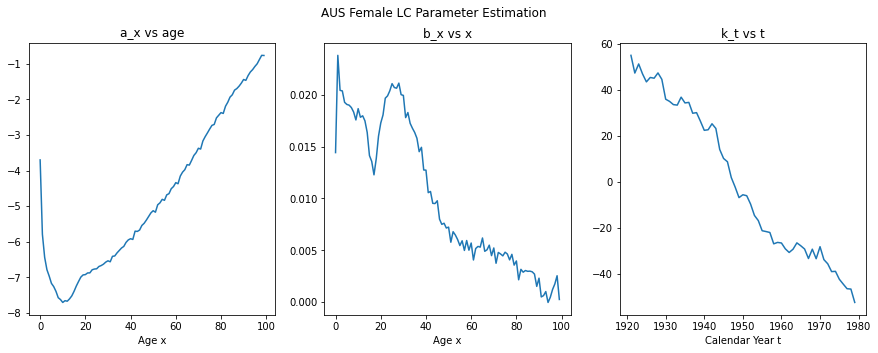

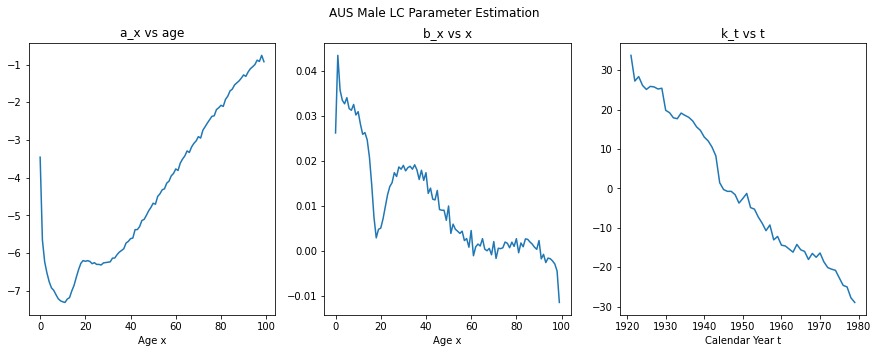

In [24]:
plotLCParams(a_xF, b_xF,k_tF, trainfemale, "Female")
plotLCParams(a_xM, b_xM,k_tM, trainmale, "Male")

### 5.2 Forecast k_t on Validation Data

As $a_x$ and $b_x$ are age-dependent rather than time-dependent, it is assumed they are constant over time. Hence, for our forecast, $k_t$ is the only parameter required to be extrapolated.

This is achieved through projection as a random walk with drift by modelling $k_t$ as an independent ARIMA(0,1,0) process.
$$k_t = k_{t-1} + \gamma + e_t$$
where $e_t ~ N(0,\sigma_\epsilon^2)$ and $\gamma$ is the drift

In [25]:
def LCForecast(train, val, k_t, G):
    # fit ARIMA(0,1,0) to k_t
    model = ARIMA(k_t, order=(0,1,0), trend = "t")
    model_fit = model.fit()
    
    # forecast k_t and confidence intervals
    forecast = model_fit.get_forecast(steps=len(val.Year.unique()))
    k_t_forecast = forecast.predicted_mean
    k_t_forecast_ci = forecast.conf_int(alpha = 0.05)

    # plot training and forecasted values
    ax4 = plt.subplot(1,1,1)
    ax4.plot(train.Year.unique(), k_t, label=f'{G} Train')
    ax4.plot(val.Year.unique(), k_t_forecast, label=f'{G} Forecast (95% CI)')
    ax4.fill_between(val.Year.unique(), k_t_forecast_ci[:,0], k_t_forecast_ci[:,1], alpha=.25)
    ax4.set_xlabel('Calendar Year t')
    ax4.set_ylabel('k_t')
    ax4.legend(loc='upper right')

    return k_t_forecast

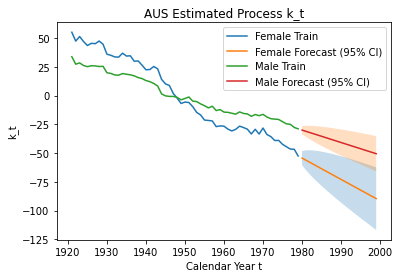

In [26]:
k_t_forecastF = LCForecast(trainfemale, valfemale, k_tF, "Female")
k_t_forecastM = LCForecast(trainmale, valmale, k_tM, "Male")
plt.title(f"{country} Estimated Process k_t")
plt.savefig(f"plots/{country} Estimated Process k_t")


### 5.3 Model Predictions

In [27]:
def fitLC(data, a_x, b_x, k_t): 
    # calculate log(mx) = ax + b_x * k_t
    fitted = np.array([a_x]) + np.dot(np.array([k_t]).T, np.array([b_x]))

    # change to dataframe 
    fitted_df = pd.DataFrame(fitted)

    # add column names
    fitted_df.columns = data.Age.unique()

    # add Year column
    fitted_df['Year'] = data.Year.unique()

    # melt the dataframe
    fitted_dfmelt = fitted_df.melt(id_vars=['Year'], value_name='pred_logmx', var_name='Age')

    # calculate mx = exp(log(mx))
    fitted_dfmelt['pred_mx'] = fitted_dfmelt['pred_logmx'].apply(lambda x: np.exp(x))

    # merge train and fitted data
    merge = pd.merge(data, fitted_dfmelt, on=['Year', 'Age'])

    # add residuals column
    merge['residuals'] = merge['pred_logmx'] - merge['logmx']

    return merge


In [144]:
LC_trainF = fitLC(trainfemale, a_xF, b_xF, k_tF)
LC_valF = fitLC(valfemale, a_xF, b_xF, k_t_forecastF)
LC_trainM = fitLC(trainmale, a_xM, b_xM, k_tM)
LC_valM = fitLC(valmale, a_xM, b_xM, k_t_forecastM)

LC_trainF['Year']= LC_trainF['Year'].astype('int')
LC_valF['Year']= LC_valF['Year'].astype('int')
LC_trainM['Year']= LC_trainM['Year'].astype('int')
LC_valM['Year']= LC_valM['Year'].astype('int')

### 5.4 Model Assessment

Plots of prediction 

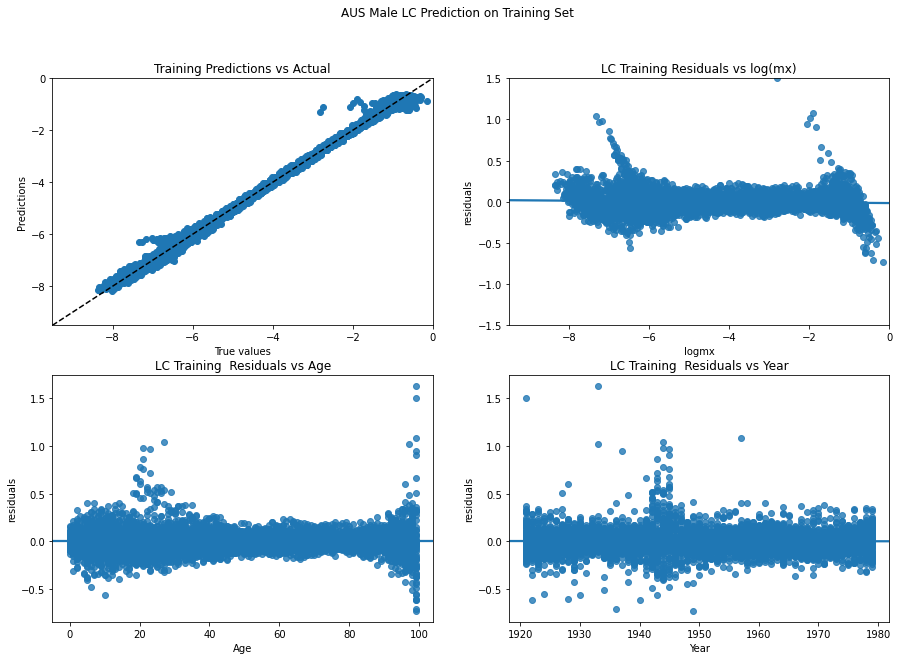

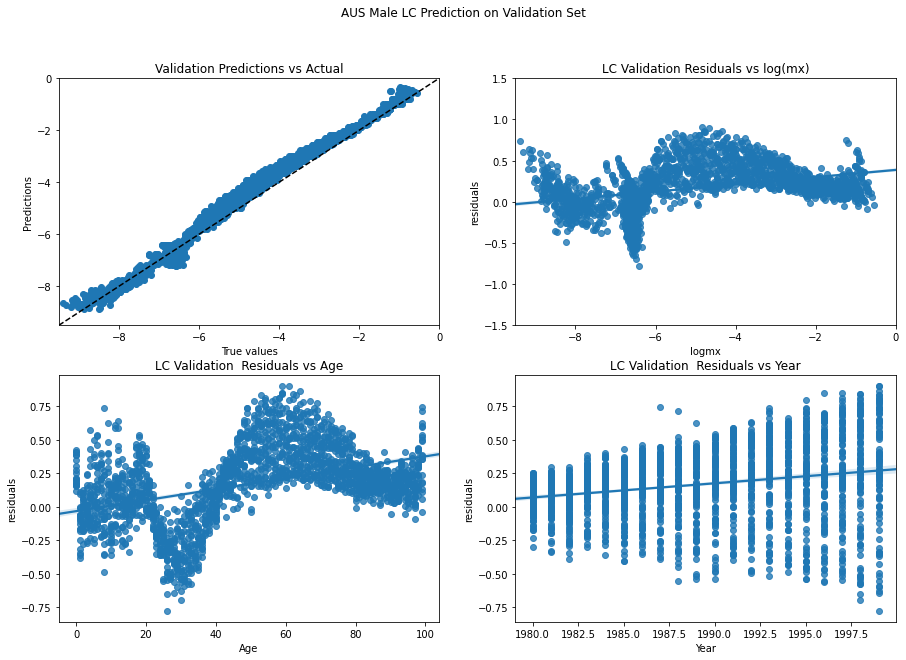

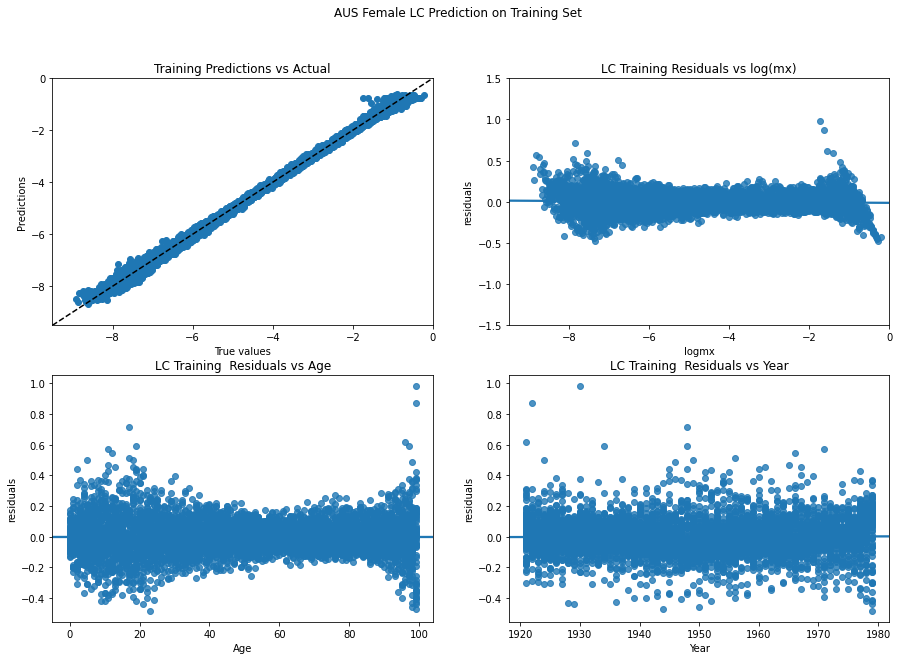

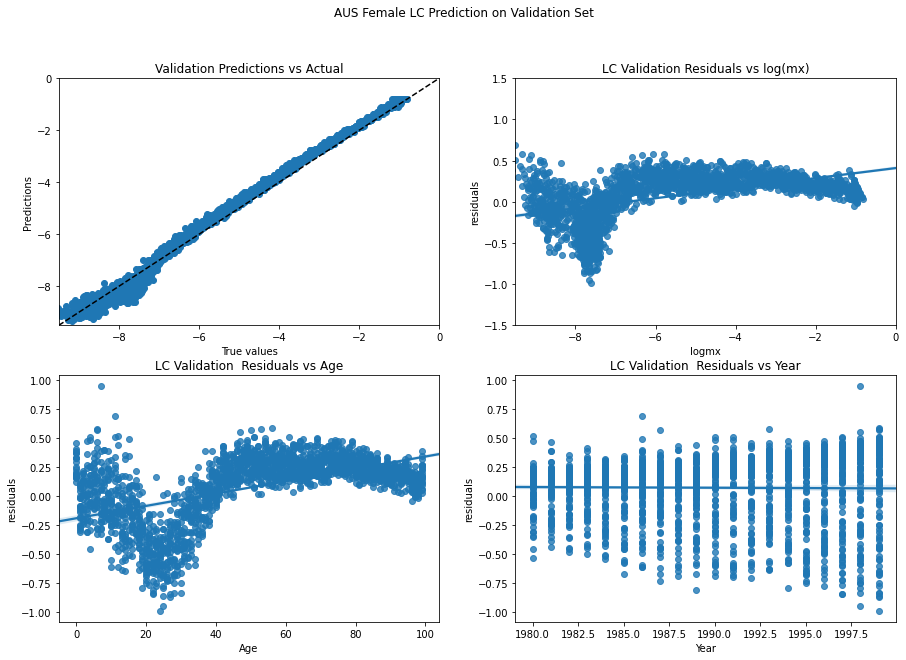

In [29]:
plotPredictions(LC_trainM, 'LC', 'Training', "Male")
plotPredictions(LC_valM, 'LC', 'Validation', "Male")
plotPredictions(LC_trainF, 'LC', 'Training', "Female")
plotPredictions(LC_valF, 'LC', 'Validation', "Female")

Plot of predictions vs age

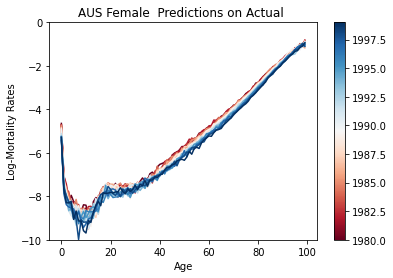

In [147]:
plotRatesVsAge(LC_valF, '', 'Actual', 'Female')

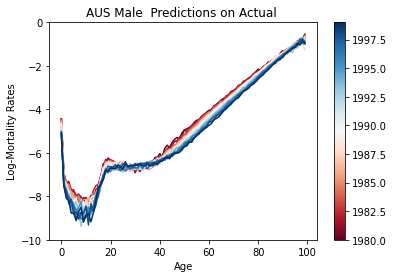

In [148]:
plotRatesVsAge(LC_valM, '', 'Actual', 'Male')

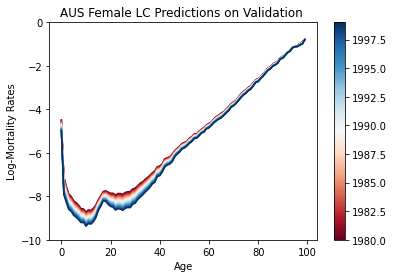

In [149]:
plotRatesVsAge(LC_valF, 'LC', 'Validation', 'Female')

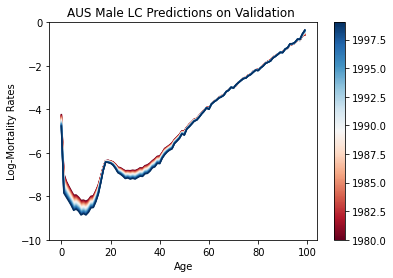

In [150]:
plotRatesVsAge(LC_valM, 'LC', 'Validation', 'Male')

Heatmap of prediction vs actual residuals

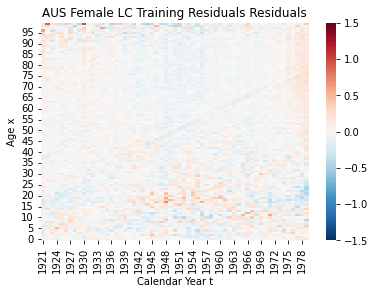

In [141]:
residualsHeatmap(LC_trainF, 'LC', 'Training', 'Female')


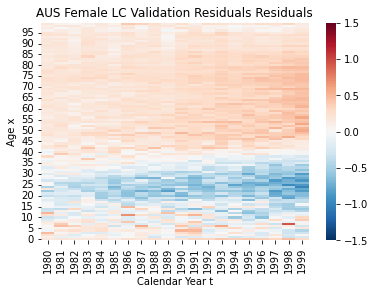

In [35]:
residualsHeatmap(LC_valF, 'LC', 'Validation', 'Female')


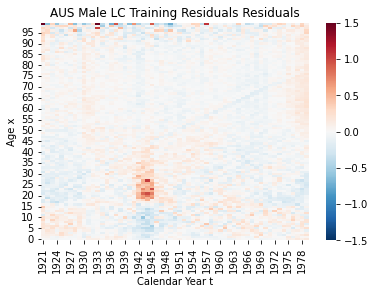

In [36]:
residualsHeatmap(LC_trainM, 'LC', 'Training', 'Male')


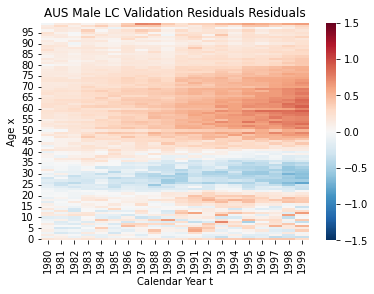

In [37]:
residualsHeatmap(LC_valM, 'LC', 'Validation', 'Male')

Calculation of MSE

The mean squared error was then calculated between the Lee Carter model's estimates of $m_x$ and the raw data's $m_x$. This serves as the baseline for our neural networks to beat.

In [38]:
mseLCTrainF = mean_squared_error(LC_trainF['mx'], LC_trainF['pred_mx'])
mseLCValF = mean_squared_error(LC_valF['mx'], LC_valF['pred_mx'])

mseLCTrainM = mean_squared_error(LC_trainM['mx'], LC_trainM['pred_mx'])
mseLCValM = mean_squared_error(LC_valM['mx'], LC_valM['pred_mx'])

mseTrain = {"Lee Carter": [mseLCTrainF, mseLCTrainM, (mseLCTrainF + mseLCTrainM)/2]}
mseVal = {"Lee Carter": [mseLCValF, mseLCValM, (mseLCValF + mseLCValM)/2]}


## 6. Deep Learning Model 1: GRU

### Helper functions

In [39]:
#Source: https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/
def timeseries_dataset_one_step(features, labels, input_sequence_length): 
    return tf.keras.preprocessing.timeseries_dataset_from_array(features[:-1], \
            np.roll(labels, -input_sequence_length, axis=0)[:-1], \
            input_sequence_length)

In [40]:
def GRUDataProcessing(data, T0):
  xmat = np.zeros((1, T0, 1))
  ymat = np.zeros((1, 1))
  YAmat = np.zeros((1, 2))
  for age in range(data.Age.max()):
    inputdata = data[data['Age'] == age].drop(columns = ["mx"])

    # Predict the next year ahead.
    ahead = 1

    # The index of the first target.
    delay = (T0+ahead-1)

    DS = \
      timeseries_dataset_one_step(
        inputdata,
        inputdata,
        T0
        )

    x_age = np.concatenate(list(DS.map(lambda x, y: x)))
    y_age = np.concatenate(list(DS.map(lambda x, y: y)))

    # append the data to the matrices
    xmat= np.append(xmat, x_age[:, :, 2:], axis = 0)
    ymat = np.append(ymat, y_age[:, 2:], axis= 0)
    YAmat = np.append(YAmat, y_age[:, 0:2], axis= 0)
  
  # remove the first row of zeros (used for initialization)
  xmat = xmat[1:]
  ymat = ymat[1:]
  YAmat = YAmat[1:]
  return xmat, ymat, YAmat

### 6.1 Prepare the data

In [41]:
# set parameters
T0 = 10 # lookback period

# data processing
x_trainF, y_trainF, trainF_AY = GRUDataProcessing(trainfemale, T0)
x_trainM, y_trainM, trainM_AY  = GRUDataProcessing(trainmale, T0)
x_valF, y_valF, valF_AY = GRUDataProcessing(valfemale, T0)
x_valM, y_valM, valM_AY = GRUDataProcessing(valmale, T0)
x_testF, y_testF, testF_AY = GRUDataProcessing(testfemale, T0)
x_testM, y_testM, testM_AY = GRUDataProcessing(testmale, T0)

In [42]:
def combinedata(xdataF, ydataF, xdataM, ydataM, F_AY, M_AY):   
    numRows = xdataF.shape[0]
    genderIndicator = np.tile([0,1], numRows) #note, 0 is Female

    yDATA = np.zeros((numRows * 2, 1))
    xDATA = np.zeros((numRows * 2, T0, 1))
    AY = np.zeros((numRows * 2, 2))

    for l in range(numRows):
        xDATA[l*2] = xdataF[l]
        xDATA[l*2 + 1] = xdataM[l]
        yDATA[l*2] = ydataF[l]
        yDATA[l*2 + 1] = ydataM[l]
        AY[l*2] = F_AY[l]
        AY[l*2 + 1] = M_AY[l]
    return xDATA, yDATA, genderIndicator, AY

x_train, y_train, genderIndicator_train, AY_train = combinedata(x_trainF, y_trainF, x_trainM, y_trainM, trainF_AY, trainM_AY)
x_val, y_val, genderIndicator_val, AY_val = combinedata(x_valF, y_valF, x_valM, y_valM, valF_AY, valM_AY)
x_test, y_test, genderIndicator_test, AY_test = combinedata(x_testF, y_testF, x_testM, y_testM, testF_AY, testM_AY)


In [43]:
# scale the data
x_min = x_train.min(axis = 0).min(axis = 0).min(axis = 0)
x_max = x_train.max(axis = 0).max(axis = 0).max(axis = 0)
f = lambda x: 2 * (x - x_min) / (x_min - x_max) - 1
x_train= f(x_train)
x_val = f(x_val)
x_test = f(x_test)

# append gender
x_train = [x_train, genderIndicator_train]
x_val = [x_val, genderIndicator_val]
x_test = [x_test, genderIndicator_test]

### 6.2 Define the model

In [44]:
def model_builder(hp):
    layers = hp.Int('layers', 1,3)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.01])

    inp = Input(shape=(T0, 1), name = "input")
    gender = Input(shape = (1), name = "gender")
    
    x = inp
    for i in range(layers):
        x = GRU(units = hp.Int(f'neurons_{i}', min_value = 5, max_value = 20, step = 5), activation = activation, return_sequences = True, name = f"GRU{i+1}")(x)
    x = GRU(units = hp.Int(f'final_neurons', min_value = 5, max_value = 20, step = 5), activation = activation, name = f"FinalGRU")(x)
    concat = Concatenate(name = "combined")([x, gender])
    output = Dense(1, name = "Output", activation =  "linear")(concat)
    modelGRU = Model(inputs = [inp, gender], outputs = [output])
    modelGRU.compile(loss="mse", optimizer=Adam(learning_rate = learning_rate))

    return modelGRU

### 6.3 Fit the model

In [45]:
tuner = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_loss',
    max_trials = 20,
    overwrite = True,
    seed = 17,
    directory = "BOGRU10")

tuner.search_space_summary()

Search space summary
Default search space size: 5
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01], 'ordered': True}
neurons_0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 5, 'sampling': None}
final_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 5, 'sampling': None}


In [46]:
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

tuner.search(
    x_train, y_train, 
    batch_size = 20,
    epochs = 100,
    validation_data = (x_val, y_val), 
    callbacks = [es], 
    verbose = 1)

Trial 20 Complete [00h 01m 20s]
val_loss: 0.03111901506781578

Best val_loss So Far: 0.017986537888646126
Total elapsed time: 00h 53m 00s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner.results_summary()

Results summary
Results in BOGRU10\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 1
activation: relu
learning_rate: 0.01
neurons_0: 20
final_neurons: 20
neurons_1: 20
neurons_2: 5
Score: 0.017986537888646126
Trial summary
Hyperparameters:
layers: 1
activation: relu
learning_rate: 0.01
neurons_0: 20
final_neurons: 20
neurons_1: 20
neurons_2: 15
Score: 0.01909351535141468
Trial summary
Hyperparameters:
layers: 1
activation: tanh
learning_rate: 0.01
neurons_0: 20
final_neurons: 20
neurons_1: 20
neurons_2: 5
Score: 0.01922379992902279
Trial summary
Hyperparameters:
layers: 3
activation: tanh
learning_rate: 0.001
neurons_0: 20
final_neurons: 20
neurons_1: 5
neurons_2: 20
Score: 0.01965450495481491
Trial summary
Hyperparameters:
layers: 1
activation: tanh
learning_rate: 0.001
neurons_0: 20
final_neurons: 5
neurons_1: 20
neurons_2: 20
Score: 0.01982983946800232
Trial summary
Hyperparameters:
layers: 3
activation: relu
learning_rate: 0.001
neurons_0: 20
final_ne

In [48]:
best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'layers': 1,
 'activation': 'relu',
 'learning_rate': 0.01,
 'neurons_0': 20,
 'final_neurons': 20,
 'neurons_1': 20,
 'neurons_2': 5}

In [49]:
bestGRUModel = tuner.get_best_models()[0]
bestGRUModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                                  
 GRU1 (GRU)                     (None, 10, 20)       1380        ['input[0][0]']                  
                                                                                                  
 FinalGRU (GRU)                 (None, 20)           2520        ['GRU1[0][0]']                   
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                              

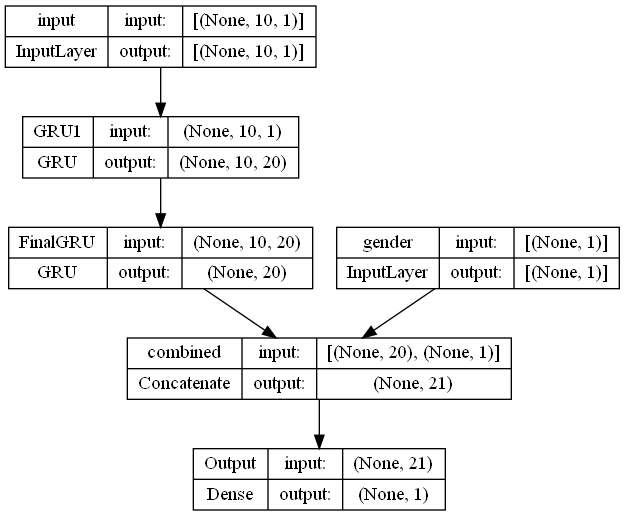

In [50]:
plot_model(bestGRUModel, show_shapes=True)

In [51]:
hist = bestGRUModel.fit(x = x_train, y = y_train, epochs = 100, validation_data = (x_val, y_val), callbacks = [es])

Epoch 1/100
304/304 [==============================] - 4s 8ms/step - loss: 0.0187 - val_loss: 0.0317
Epoch 2/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0195 - val_loss: 0.0500
Epoch 3/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0182 - val_loss: 0.0201
Epoch 4/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0166 - val_loss: 0.0288
Epoch 5/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0180 - val_loss: 0.0348
Epoch 6/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0185 - val_loss: 0.0214
Epoch 7/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0189 - val_loss: 0.0183
Epoch 8/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 9/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0176 - val_loss: 0.0201
Epoch 10/100
304/304 [==============================] - 2s 7ms/step - loss: 0.0171 - val_lo

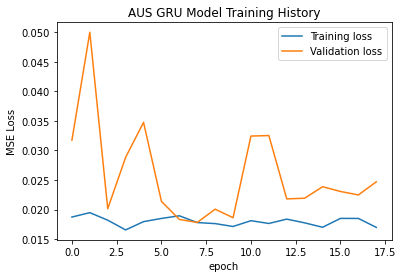

<Figure size 432x288 with 0 Axes>

In [52]:
plot_train_history(hist, "GRU Model")

### 6.4 Model Predictions

In [53]:
GRU_train = nnPredictions(bestGRUModel, x_train, y_train.flatten())
GRU_train = pd.concat([pd.DataFrame(GRU_train), pd.DataFrame(AY_train, columns = ['Year','Age']).astype('int'), pd.DataFrame(genderIndicator_train, columns = ['Gender'])], axis = 1)

GRU_val = nnPredictions(bestGRUModel, x_val, y_val.flatten())
GRU_val = pd.concat([pd.DataFrame(GRU_val), pd.DataFrame(AY_val, columns = ['Year','Age']).astype('int'),pd.DataFrame(genderIndicator_val, columns = ['Gender'])], axis = 1)

GRU_trainF = GRU_train[GRU_train['Gender'] == 0]
GRU_valF = GRU_val[GRU_val['Gender'] == 0]

GRU_trainM = GRU_train[GRU_train['Gender'] == 1]
GRU_valM = GRU_val[GRU_val['Gender'] == 1]


62/62 [==============================] - 0s 3ms/step


### 6.5 Model Assessment

Plot predictions

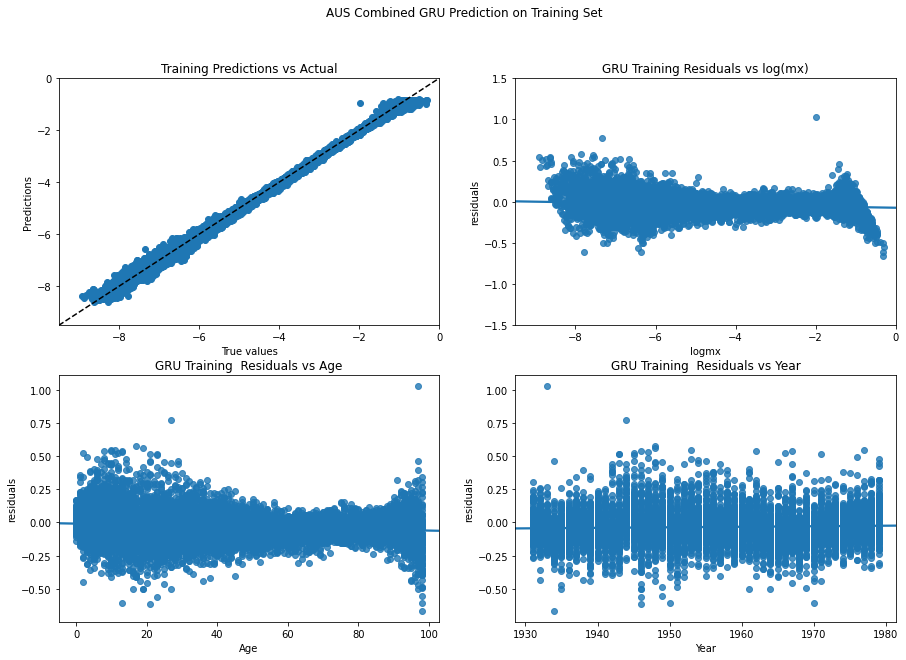

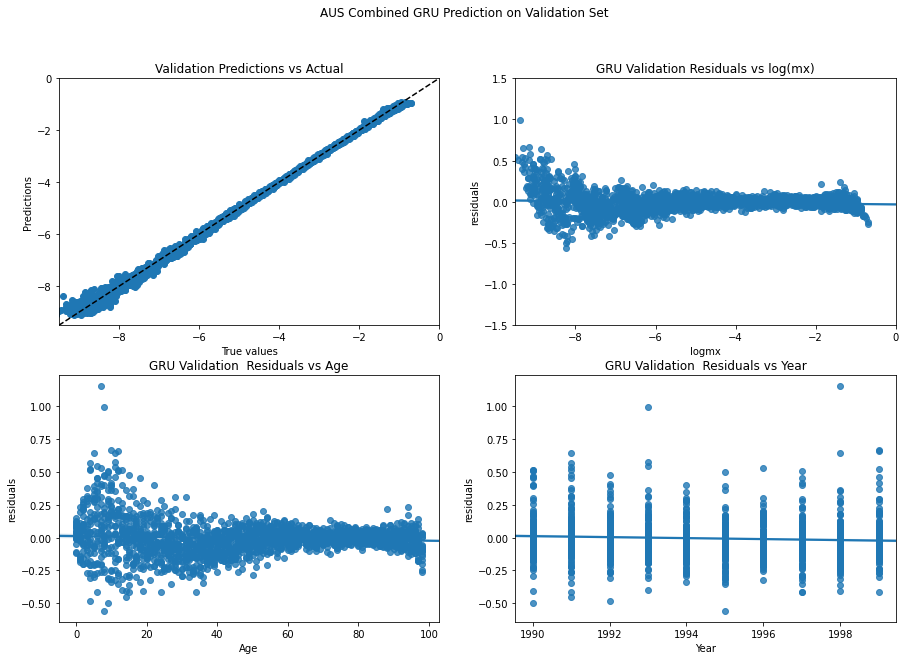

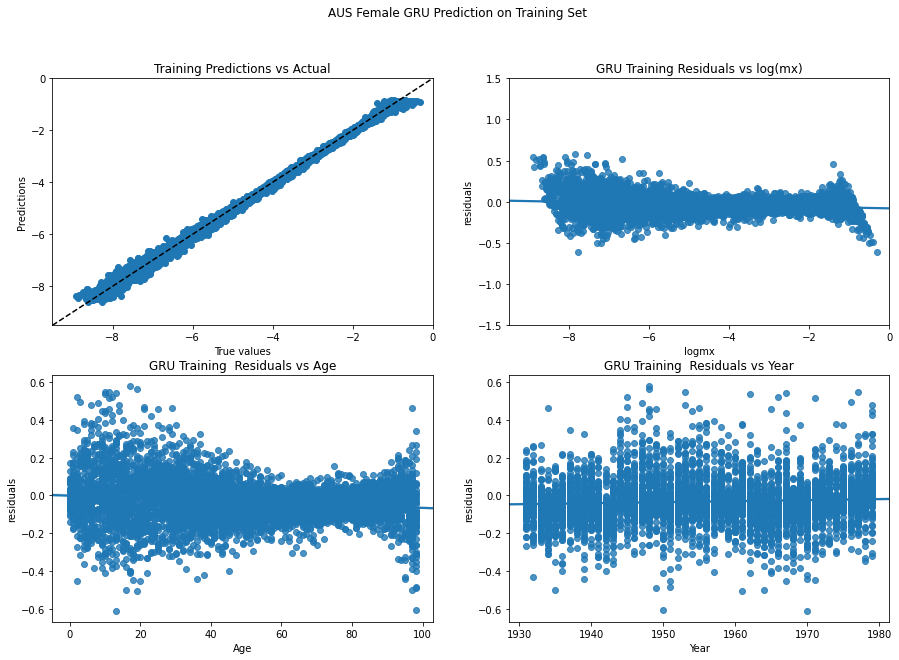

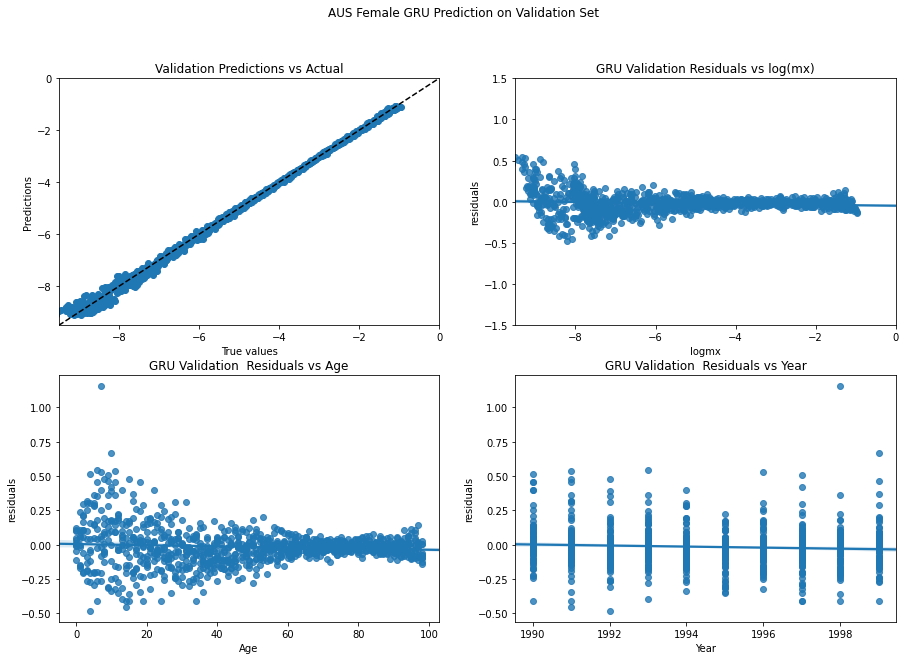

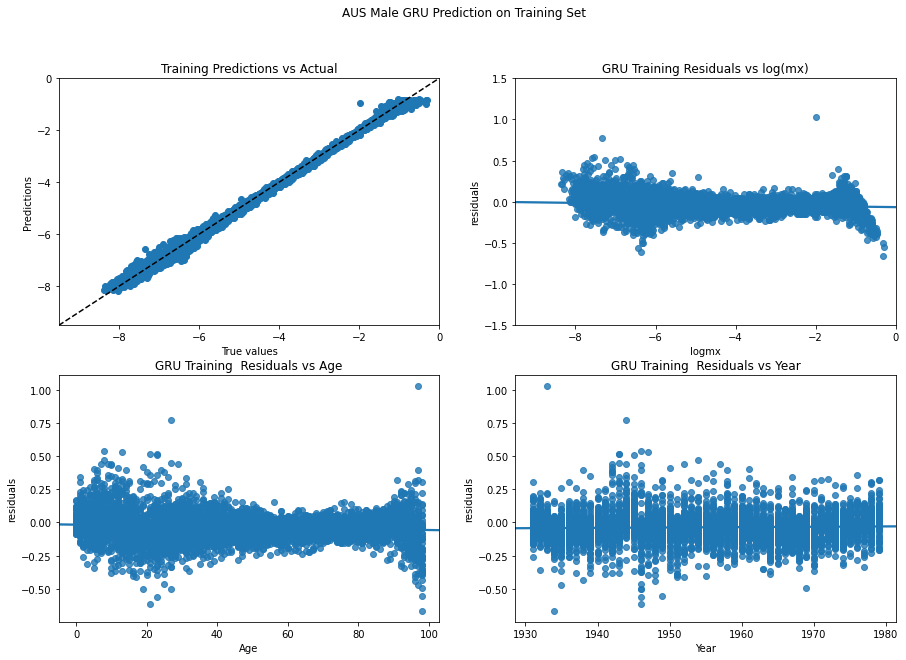

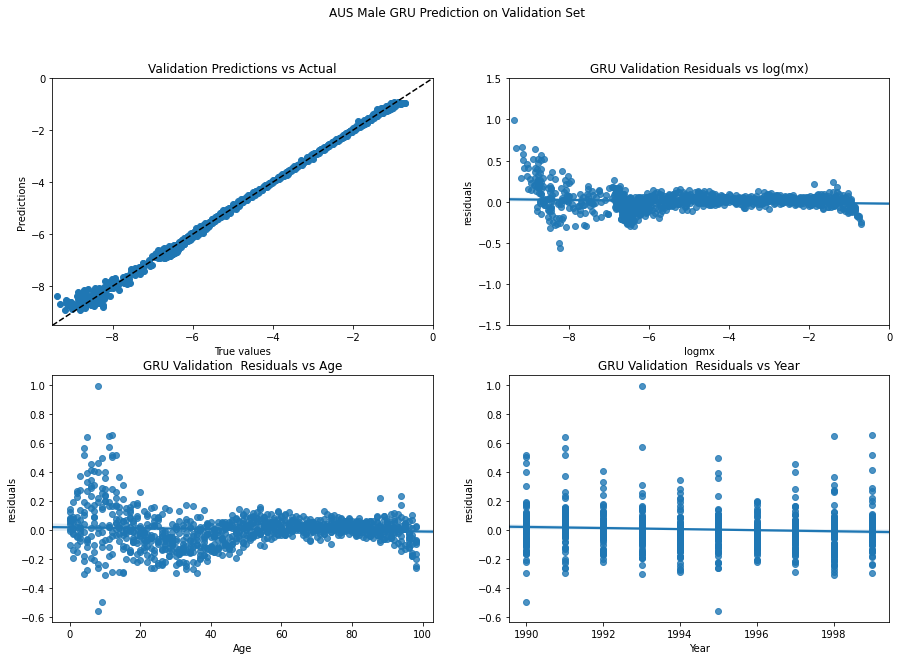

In [54]:
plotPredictions(GRU_train, 'GRU','Training', 'Combined')
plotPredictions(GRU_val, 'GRU','Validation', 'Combined')

plotPredictions(GRU_trainF, 'GRU','Training', 'Female')
plotPredictions(GRU_valF, 'GRU','Validation', 'Female')

plotPredictions(GRU_trainM, 'GRU','Training', 'Male')
plotPredictions(GRU_valM, 'GRU','Validation', 'Male')

Plot of predictions vs age

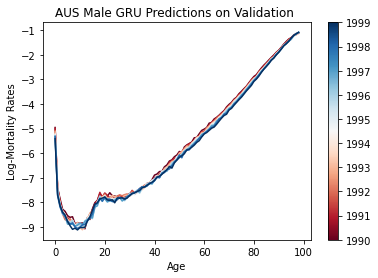

In [142]:
plotRatesVsAge(GRU_valF, 'GRU', 'Validation', 'Male')

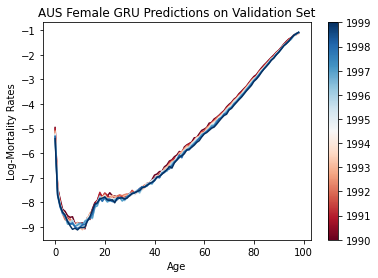

In [56]:
plotRatesVsAge(GRU_valF, 'GRU', 'Validation', 'Female')

Heatmap of predictions vs actual residuals 

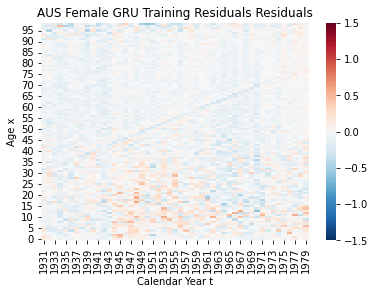

In [57]:
residualsHeatmap(GRU_trainF, 'GRU', 'Training', 'Female')

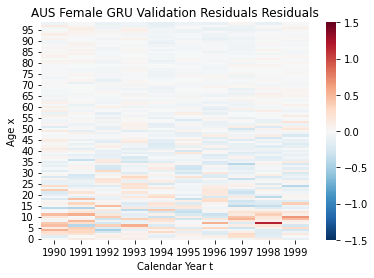

In [58]:
residualsHeatmap(GRU_valF, 'GRU', 'Validation', 'Female')

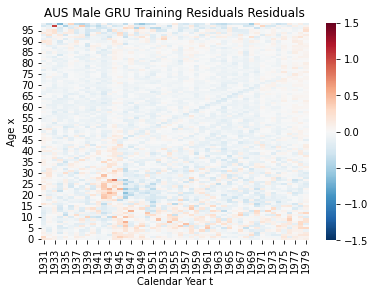

In [59]:
residualsHeatmap(GRU_trainM, 'GRU', 'Training', 'Male')

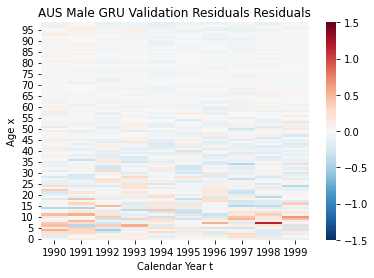

In [60]:
residualsHeatmap(GRU_valF, 'GRU', 'Validation', 'Male')

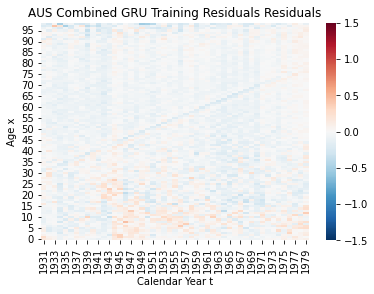

In [61]:
residualsHeatmap(GRU_train, 'GRU', 'Training', 'Combined')

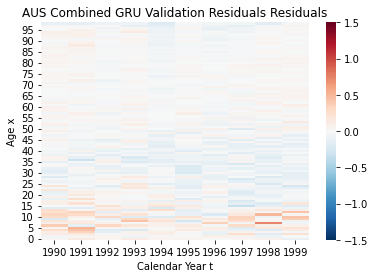

In [62]:
residualsHeatmap(GRU_val, 'GRU', 'Validation', 'Combined')

Calculation of MSE

In [63]:
mseGRUTrainF = mean_squared_error(GRU_trainF['mx'], GRU_trainF['pred_mx'])
mseGRUValF = mean_squared_error(GRU_valF['mx'], GRU_valF['pred_mx'])

mseGRUTrainM = mean_squared_error(GRU_trainM['mx'], GRU_trainM['pred_mx'])
mseGRUValM = mean_squared_error(GRU_valM['mx'], GRU_valM['pred_mx'])

mseGRUTrain = mean_squared_error(GRU_train['mx'], GRU_train['pred_mx'])
mseGRUVal = mean_squared_error(GRU_val['mx'], GRU_val['pred_mx'])

mseTrain["GRU"] = [mseGRUTrainF, mseGRUTrainM, mseGRUTrain]
mseVal["GRU"] =  [mseGRUValF, mseGRUValM, mseGRUVal]

## 7. Deep Learning Model 2: Deep and Wide

### 7.1 Data Processing

In [64]:
#separate features and targets
X_train = trainall.drop(columns = ['mx', 'logmx'])
y_train = trainall.logmx
X_val = valall.drop(columns = ['mx', 'logmx'])
y_val = valall.logmx


In [65]:
NUM_AGE, NUM_GENDER = X_train.nunique()[["Age", "Gender"]]
ct = make_column_transformer(
    (OrdinalEncoder(),["Gender"]),
    (StandardScaler(),["Year"]),
    remainder = "passthrough"
)

X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)

X_train_gender = X_train_ct[:,0]
X_val_gender = X_val_ct[:,0]

X_train_year = X_train_ct[:,1]
X_val_year = X_val_ct[:,1]

X_train_age = X_train_ct[:,2]
X_val_age = X_val_ct[:,2]

x_train = [X_train_age, X_train_gender, X_train_year]
x_val = [X_val_age, X_val_gender, X_val_year]


### 7.2 Define the model

In [66]:
def model_builder(hp):
    layers = hp.Int('layers', 1, 4)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    dropout = hp.Float('dropout', 0.0, 0.5, step = 0.1)
    gender_embedding = hp.Choice('gender_embedding', [2,3,5])
    age_embedding = hp.Choice('age_embedding', [2,3,5])
    

    age = Input(shape = [1], name = "age")
    gender = Input(shape = [1], name = "gender")
    year = Input(shape = [1], name = "year")
    
    ageEE = Embedding(input_dim = NUM_AGE, output_dim = age_embedding, name = "ageEE")(age)
    ageEE = Flatten()(ageEE)

    genderEE = Embedding(input_dim = NUM_GENDER, output_dim = gender_embedding, name = "genderEE")(gender)
    genderEE = Flatten()(genderEE)

    features = Concatenate(name = "Combined")([ageEE, genderEE, year])

    x = features
    for i in range(layers):
        x = Dense(units = hp.Float(f'neurons{i}', 10, 100, step = 10), activation = activation , name = f"hidden{i}")(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
    concat = Concatenate(name = "combined")([x, features])
    out = Dense(1, activation = "linear", name = "out")(concat)  

    DenseModel = Model([age, gender, year], out)
    DenseModel.compile(optimizer = "adam", loss = "mse")

    return DenseModel

### 7.3 Fit the model

In [67]:
tuner = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_loss',
    max_trials = 20,
    overwrite = True,
    seed = 17,
    directory = "BODense")

In [68]:
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

tuner.search(
    x_train, y_train, 
    epochs = 100,
    validation_data = (x_val, y_val), 
    callbacks = [es], 
    verbose = 1)

Trial 20 Complete [00h 00m 17s]
val_loss: 0.029855983331799507

Best val_loss So Far: 0.029855983331799507
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


In [69]:
tuner.results_summary()

Results summary
Results in BODense\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 1
activation: relu
dropout: 0.0
gender_embedding: 5
age_embedding: 2
neurons0: 100.0
neurons1: 10.0
neurons2: 10.0
neurons3: 100.0
Score: 0.029855983331799507
Trial summary
Hyperparameters:
layers: 1
activation: relu
dropout: 0.0
gender_embedding: 2
age_embedding: 2
neurons0: 100.0
neurons1: 100.0
neurons2: 80.0
neurons3: 100.0
Score: 0.03489426523447037
Trial summary
Hyperparameters:
layers: 1
activation: relu
dropout: 0.0
gender_embedding: 5
age_embedding: 2
neurons0: 100.0
neurons1: 100.0
neurons2: 30.0
neurons3: 100.0
Score: 0.036509059369564056
Trial summary
Hyperparameters:
layers: 2
activation: relu
dropout: 0.0
gender_embedding: 2
age_embedding: 2
neurons0: 100.0
neurons1: 100.0
neurons2: 100.0
neurons3: 100.0
Score: 0.0368216298520565
Trial summary
Hyperparameters:
layers: 3
activation: relu
dropout: 0.0
gender_embedding: 2
age_embedding: 2
neurons0: 100.0
neurons1

In [70]:
bestDenseModel = tuner.get_best_models()[0]
bestDenseModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 ageEE (Embedding)              (None, 1, 2)         200         ['age[0][0]']                    
                                                                                                  
 genderEE (Embedding)           (None, 1, 5)         10          ['gender[0][0]']                 
                                                                                              

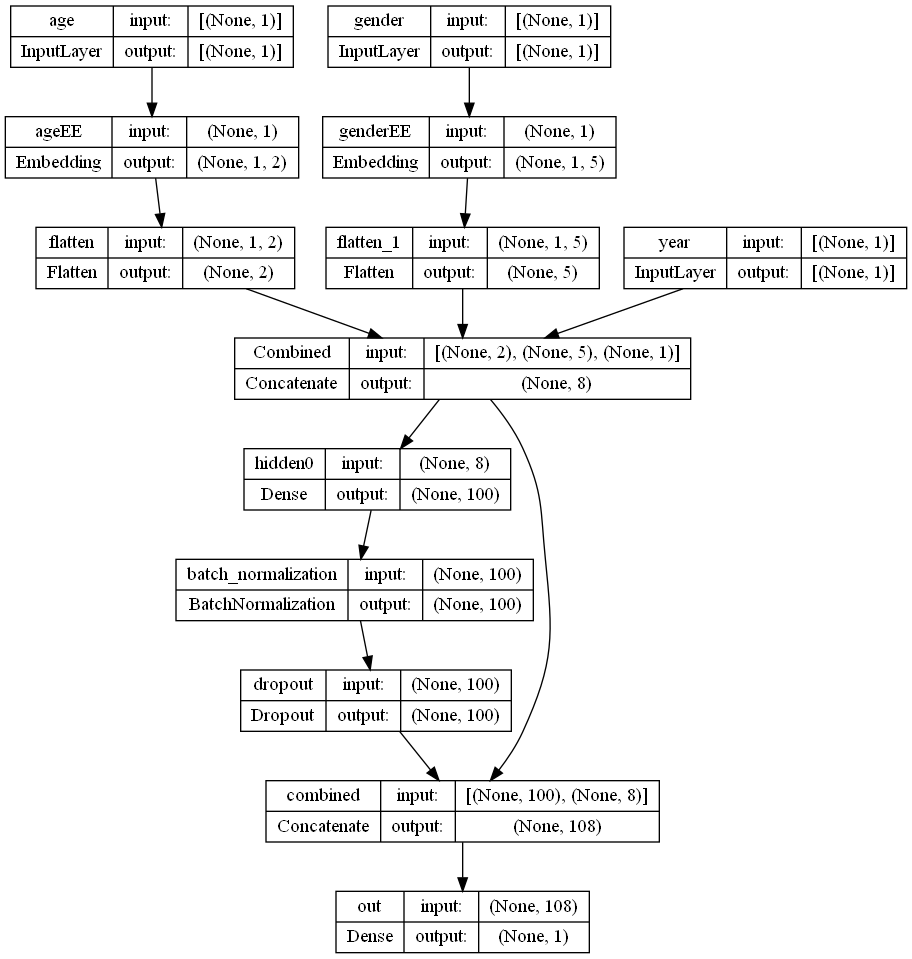

In [71]:
plot_model(bestDenseModel, show_shapes=True)

In [72]:
best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'layers': 1,
 'activation': 'relu',
 'dropout': 0.0,
 'gender_embedding': 5,
 'age_embedding': 2,
 'neurons0': 100.0,
 'neurons1': 10.0,
 'neurons2': 10.0,
 'neurons3': 100.0}

In [73]:
es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)

hist = bestDenseModel.fit(
    (X_train_age, X_train_gender, X_train_year), 
    y_train, 
    epochs = 100, 
    verbose = 1,
    callbacks = [es],
    validation_data = ((X_val_age, X_val_gender, X_val_year), y_val)
)


Epoch 1/100
369/369 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0736
Epoch 2/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0201 - val_loss: 0.0497
Epoch 3/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0926
Epoch 4/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0207 - val_loss: 0.0417
Epoch 5/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 0.0356
Epoch 6/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0205 - val_loss: 0.0440
Epoch 7/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 0.0422
Epoch 8/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0303
Epoch 9/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0198 - val_loss: 0.0465
Epoch 10/100
369/369 [==============================] - 0s 1ms/step - loss: 0.0190 - val_lo

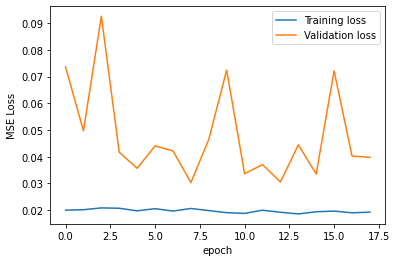

In [74]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')

plt.legend()
plt.show()

### 7.4 Model Predictions

In [75]:
Dense_train = nnPredictions(bestDenseModel, x_train, y_train)
Dense_train = pd.concat([Dense_train, X_train['Age'].astype('int'), X_train['Year'].astype('int'), X_train['Gender']], axis = 1)
Dense_val = nnPredictions(bestDenseModel, x_val, y_val)
Dense_val = pd.concat([Dense_val, X_val['Age'].astype('int'), X_val['Year'].astype('int'), X_val['Gender']], axis = 1)

# split by Gender 
Dense_trainF = Dense_train[Dense_train['Gender'] == 'Female']
Dense_valF = Dense_val[Dense_val['Gender'] == 'Female']
Dense_trainM = Dense_val[Dense_val['Gender'] == 'Male']
Dense_valM = Dense_val[Dense_val['Gender'] == 'Male']

125/125 [==============================] - 0s 594us/step


### 7.4 Model Assessment

Plot of predictions

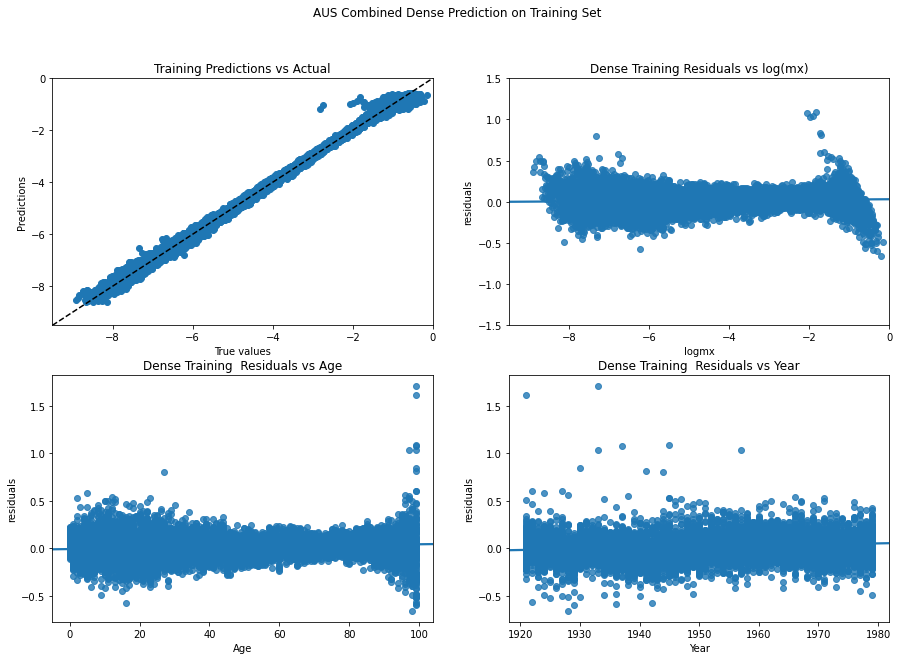

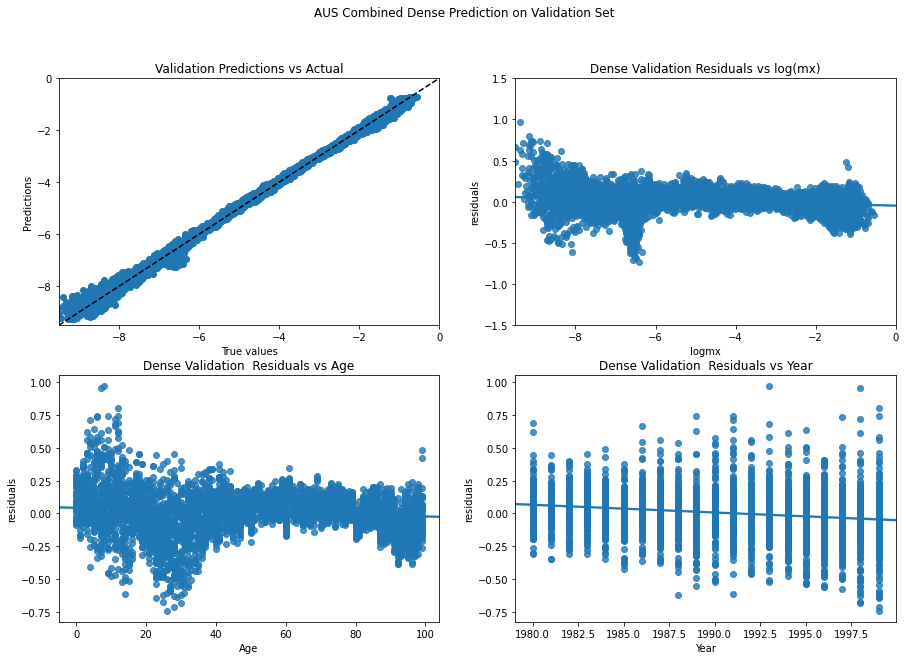

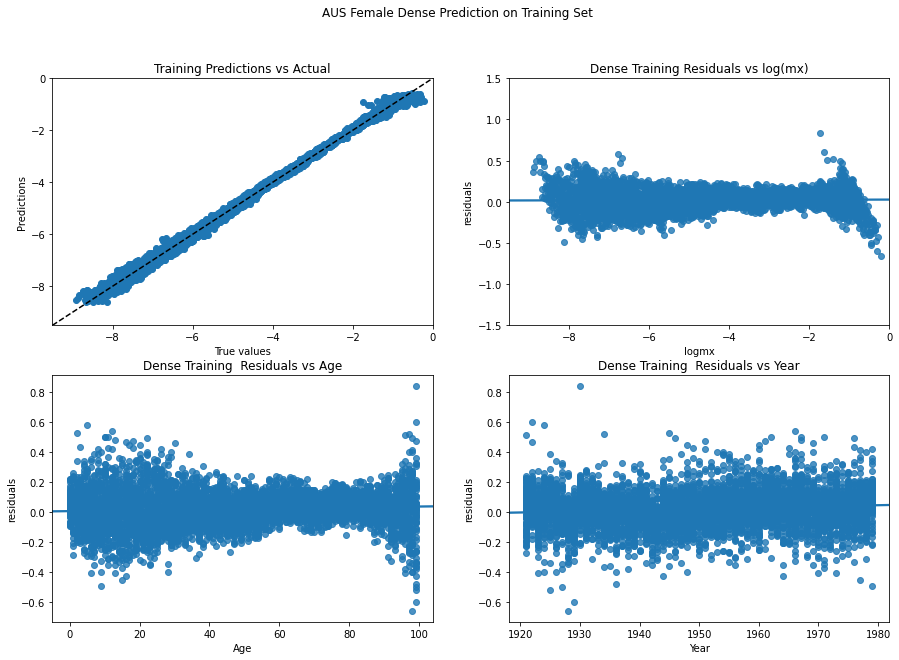

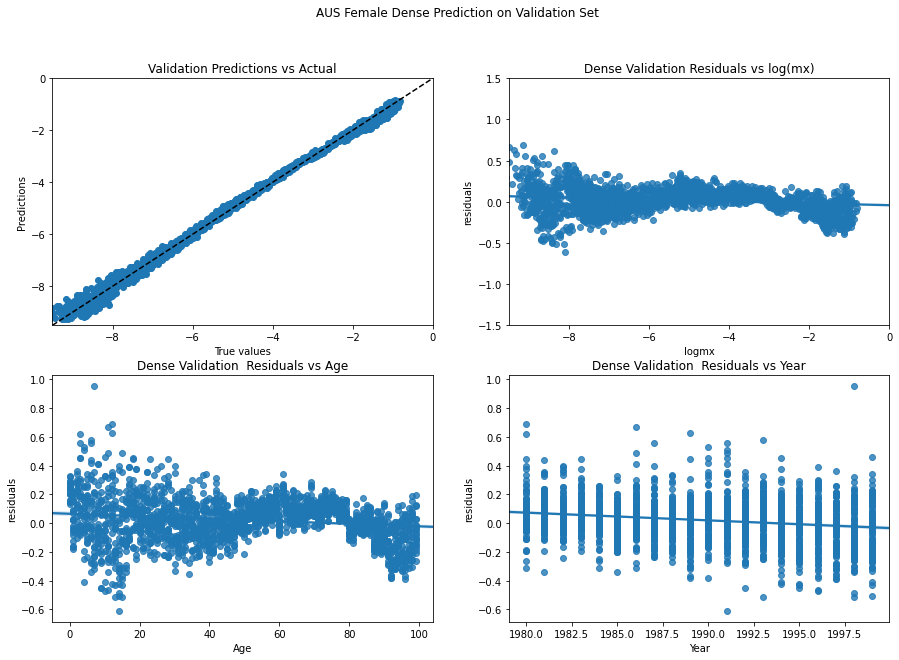

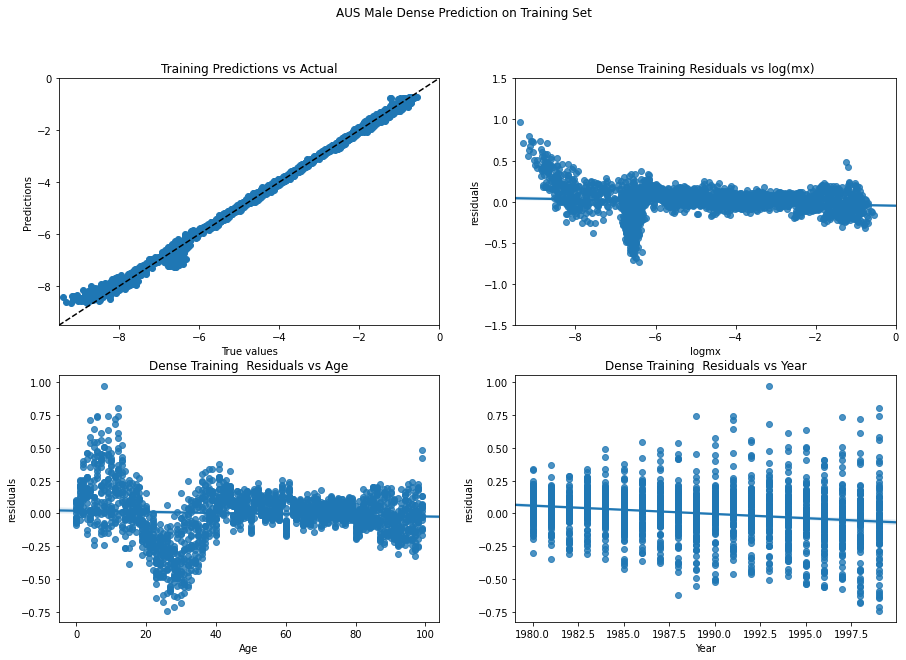

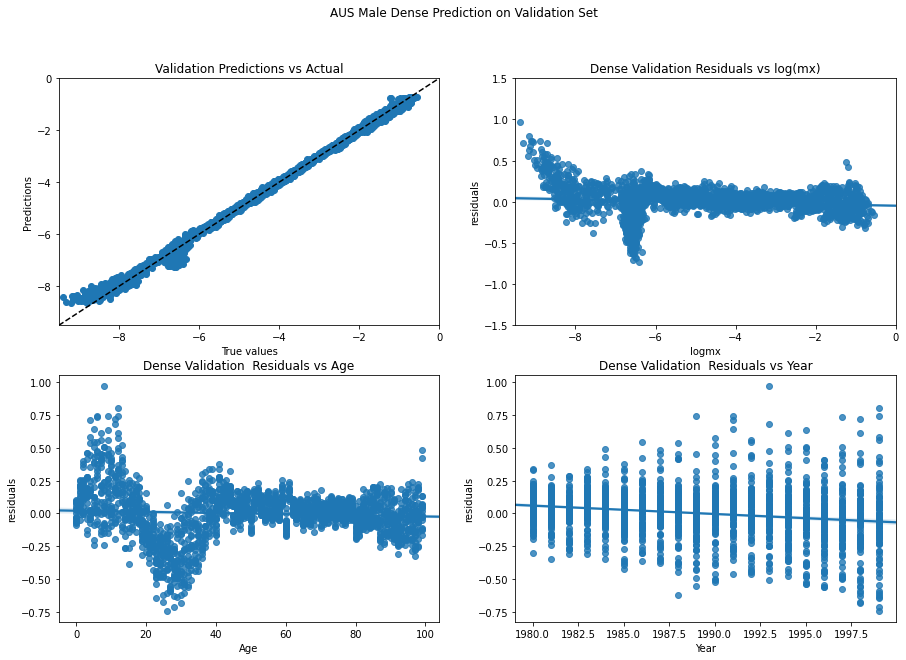

In [76]:
plotPredictions(Dense_train, 'Dense','Training', 'Combined')
plotPredictions(Dense_val, 'Dense', 'Validation', 'Combined')
plotPredictions(Dense_trainF, 'Dense','Training', 'Female')
plotPredictions(Dense_valF, 'Dense', 'Validation', 'Female')
plotPredictions(Dense_trainM, 'Dense','Training', 'Male')
plotPredictions(Dense_valM, 'Dense', 'Validation', 'Male')

Plot of predictions vs age

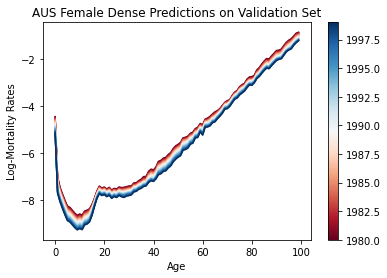

In [77]:
plotRatesVsAge(Dense_valF, 'Dense', 'Validation', 'Female')

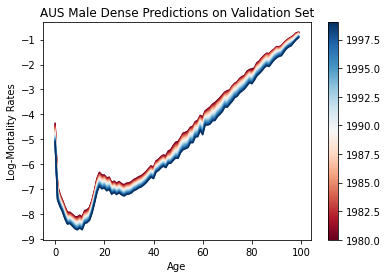

In [78]:
plotRatesVsAge(Dense_valM, 'Dense', 'Validation', 'Male')

Plot of predictions vs actual residuals

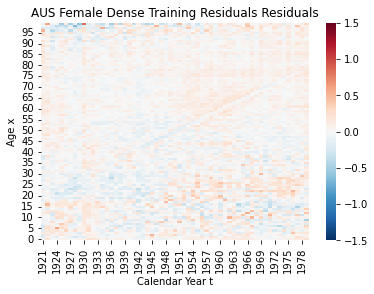

In [79]:
residualsHeatmap(Dense_trainF, 'Dense', 'Training', 'Female')

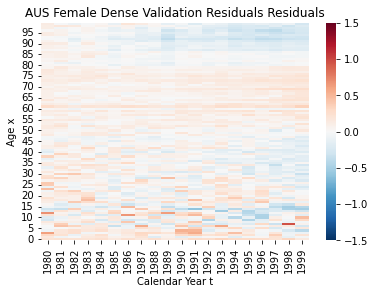

In [80]:
residualsHeatmap(Dense_valF, 'Dense', 'Validation', 'Female')

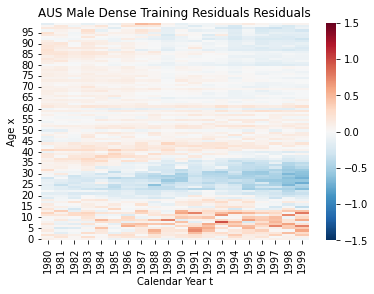

In [81]:
residualsHeatmap(Dense_trainM, 'Dense', 'Training', 'Male')

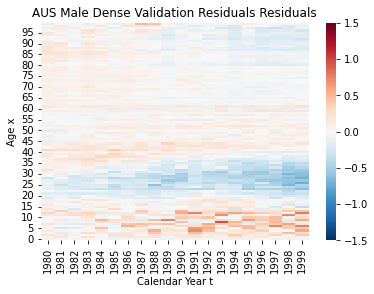

In [82]:
residualsHeatmap(Dense_valM, 'Dense', 'Validation', 'Male')

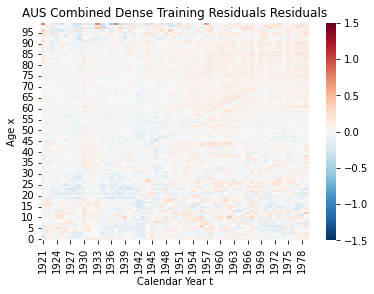

In [83]:
residualsHeatmap(Dense_train, 'Dense', 'Training', 'Combined')

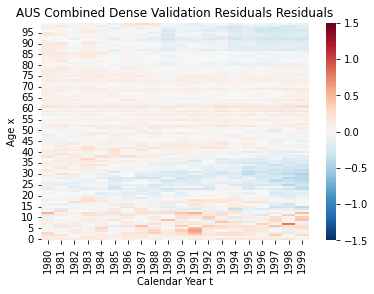

In [84]:
residualsHeatmap(Dense_val, 'Dense', 'Validation', 'Combined')

Calculation of MSE

In [85]:
mseDenseTrainF = mean_squared_error(Dense_trainF['mx'], Dense_trainF['pred_mx'])
mseDenseValF = mean_squared_error(Dense_valF['mx'], Dense_valF['pred_mx'])


mseDenseTrainM = mean_squared_error(Dense_trainM['mx'], Dense_trainM['pred_mx'])
mseDenseValM = mean_squared_error(Dense_valM['mx'], Dense_valM['pred_mx'])

mseDenseTrain = mean_squared_error(Dense_train['mx'], Dense_train['pred_mx'])
mseDenseVal = mean_squared_error(Dense_val['mx'], Dense_val['pred_mx'])

mseTrain["Dense"] = [mseDenseTrainF, mseDenseTrainM, mseDenseTrain]
mseVal["Dense"] =  [mseDenseValF, mseDenseValM, mseDenseVal]

## 8. Evaluation of Final Chosen Model on Test Data

### 8.1 Selection of Final Model

In [86]:
trainResults = pd.DataFrame(mseTrain).transpose()
trainResults.columns = ["Female", "Male", "Both"]
valResults = pd.DataFrame(mseVal).transpose()
valResults.columns = ["Female", "Male", "Both"]


In [87]:
trainResults

,Female,Male,Both
Lee Carter,0.000435,0.000597,0.000516
GRU,0.000304,0.000444,0.000374
Dense,0.000451,0.000253,0.000517


In [88]:
valResults

,Female,Male,Both
Lee Carter,0.000341,0.001184,0.000762
GRU,0.000030,0.000103,0.000066
Dense,0.000205,0.000253,0.000229


### 8.2 Model Evaluation of Selected Model on Test Data

As GRU model has lowest validation error, we fit the GRU model on the test data

In [89]:
GRU_test= nnPredictions(bestGRUModel, x_test, y_test.flatten())
GRU_test = pd.concat([pd.DataFrame(GRU_test), pd.DataFrame(AY_test, columns = ['Year','Age']).astype('int'), pd.DataFrame(genderIndicator_test, columns = ['Gender']).astype('int')], axis = 1)

# split by Gender 
GRU_testF = GRU_test[GRU_test['Gender'] == 0]
GRU_testM = GRU_test[GRU_test['Gender'] == 1]

62/62 [==============================] - 0s 2ms/step


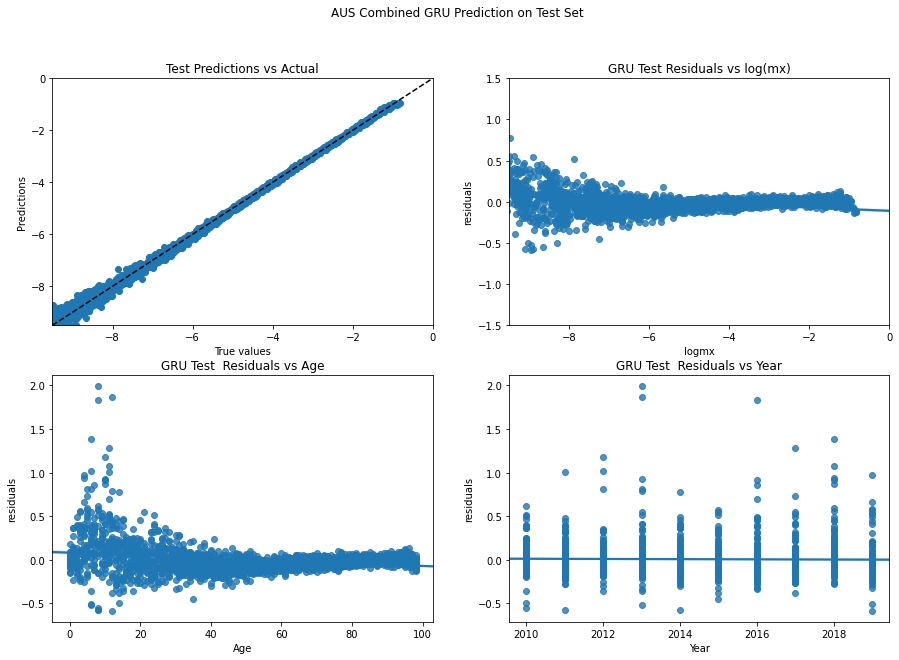

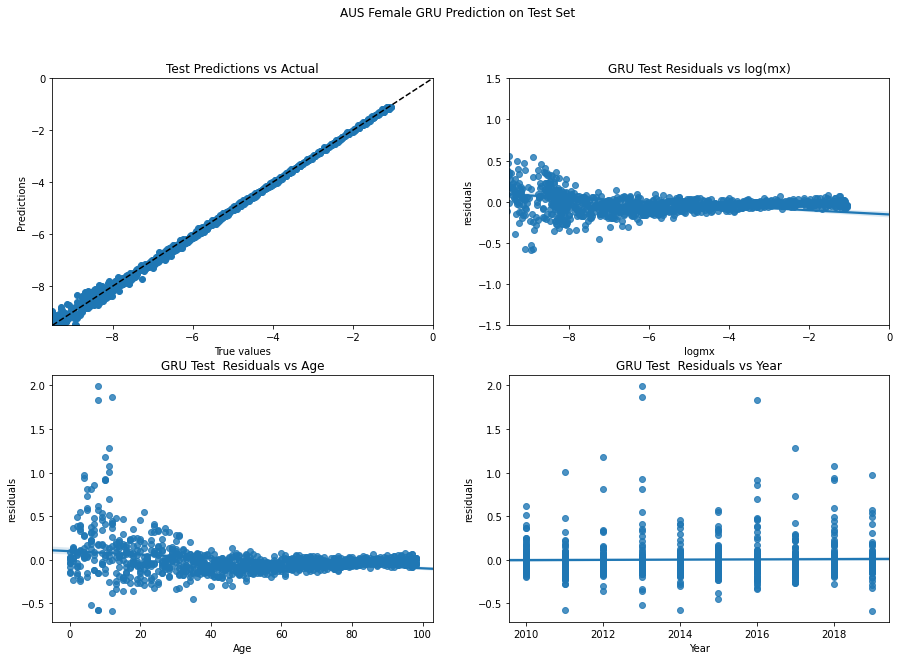

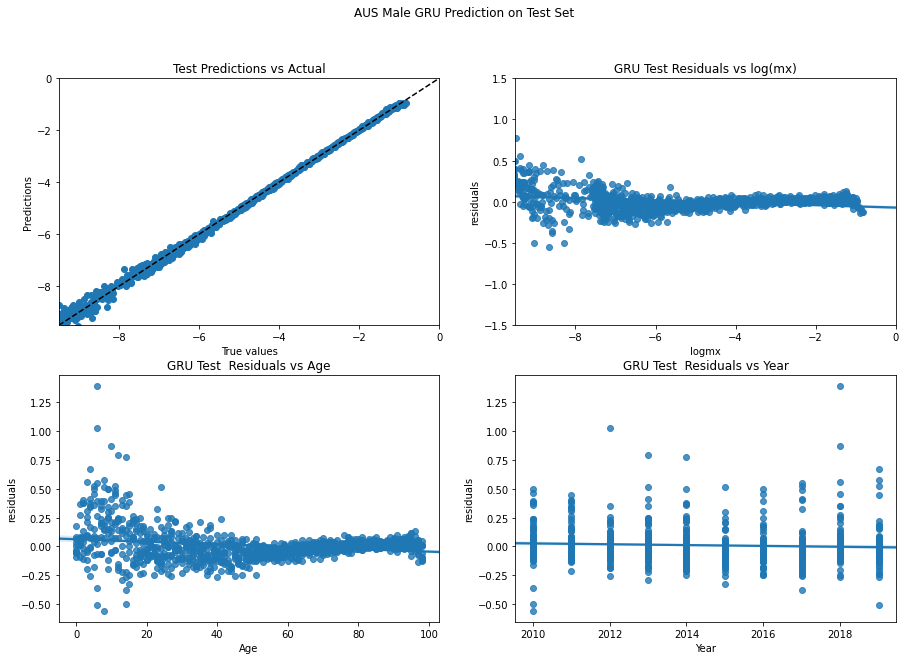

In [90]:
plotPredictions(GRU_test, 'GRU','Test', 'Combined')
plotPredictions(GRU_testF, 'GRU','Test', 'Female')
plotPredictions(GRU_testM, 'GRU','Test', 'Male')


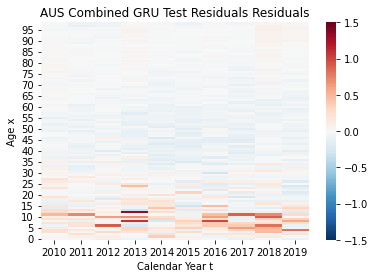

In [91]:
residualsHeatmap(GRU_test, 'GRU', 'Test', 'Combined')

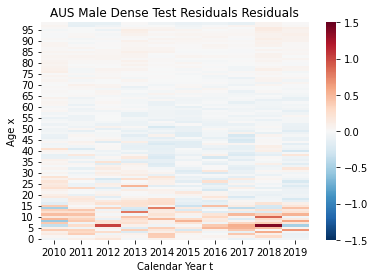

In [92]:
residualsHeatmap(GRU_testM, 'Dense', 'Test', 'Male')

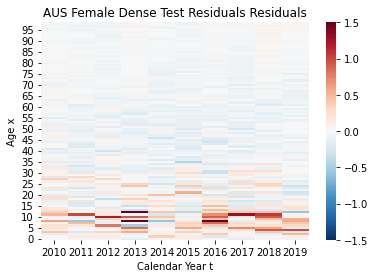

In [93]:
residualsHeatmap(GRU_testF, 'Dense', 'Test', 'Female')

In [94]:
print(f"GRU Combined Test Error: {mean_squared_error(GRU_test['mx'], GRU_test['pred_mx']):.20f}")
print(f"GRU Female Test Error: {mean_squared_error(GRU_testF['mx'], GRU_testF['pred_mx']):.20f}")
print(f"GRU Male Test Error: {mean_squared_error(GRU_testM['mx'], GRU_testM['pred_mx']):.20f}")

GRU Combined Test Error: 0.00001913628648892884
GRU Female Test Error: 0.00000905701799088287
GRU Male Test Error: 0.00002921555498697480
